In [1990]:
import random
import numpy as np
import matplotlib.pyplot as plt

from os import listdir
from os.path import join, isfile
from deap import base, creator, tools, algorithms


In [1991]:
def get_data_from_file(path: str):
    file = open(path, "r")
    data = np.loadtxt(file, delimiter=" ", dtype=np.int32).tolist()
    file.close()
    return data

def get_paths_of_dir(path: str, extension: str):
    return [join(path, f) for f in listdir(path)
            if isfile(join(path, f)) and f.endswith(extension)]


In [1992]:
inDirPath = "../../Input/"
inPaths = get_paths_of_dir(inDirPath, extension=".in")

In [1993]:
n_problem = int(input("Elige el problema (1-5): "))

inDirFiles = listdir(inDirPath)
file_name = inDirFiles[n_problem - 1]

path = inPaths[n_problem - 1]
prob = get_data_from_file(path)

## Variable meanings.

* R = Number of rows.
* C = Number of columns.
* F = Number of vehicles.
* N = Pre-booked rides.
* B = Per-ride bonus for starting the ride on time.
* T = Simulation steps = distance between start and end.

In [1994]:
# Problem data.
_, _, F, N, B, T = prob[0]

# Rides.
rides = prob[1:]

Bonus:
* Earn points proportional to distance of ride.
* Bonus if started on time. 

In [1995]:
toolbox = base.Toolbox()

In [1996]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

In [1997]:
toolbox.register("attribute", random.randint, 0, F - 1)
toolbox.register("individual", tools.initRepeat,
                 creator.Individual, toolbox.attribute, n=N)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [1998]:
def dis(a, b): return np.abs(a[0] - b[0]) + np.abs(a[1]-b[1])

In [1999]:
def sort_rides(car_rides):
    def sort_ride(ride):
        a, b, x, y, s, f = ride
        origin = [a, b]
        destiny = [x, y]
        distance = dis(origin, destiny)
        return s + f - distance

    return sorted(car_rides, key=lambda ride: sort_ride(ride[1]))


def sort_rides_with_index(rides):
    rides = enumerate(rides)

    order, s_rides = [], []

    _sorted = sort_rides(rides)
    for o, s in _sorted:
        order.append(o)
        s_rides.append(s)

    return order, s_rides


# Sort rides to prevent doing it on every iteration.
order, s_rides = sort_rides_with_index(rides)


In [2000]:
def eval_ind(ind):
    initial_values = [[0, 0], 0, 0]
    cars = [initial_values for _ in range(F)]

    for i, ride in enumerate(s_rides):
        a, b, x, y, s, f = ride
        origin = [a, b]
        destiny = [x, y]
        earliest_start = s
        latest_finish = f

        pos, step, fit = cars[ind[i]]

        # 1.- Go to origin.
        step += dis(pos, origin)

        # 2.- If arrived before the earliest time. Wait and earn bonus.
        if step <= earliest_start:
            fit += B
            step = earliest_start

        # 3.- Go to destiny.
        dis_ori_des = dis(origin, destiny)
        step += dis_ori_des

        # 4.- If reached destiny before latest finish. Earn points.
        if step <= latest_finish:
            fit += dis_ori_des

        # 5.- Update position and car.
        pos = destiny

        cars[ind[i]] = pos, step, fit

        # 6.- Check if reached max distance with one vehicle.
        if step > T:
            break

    # Sum up all the fitness.
    fitness = np.sum([fit for _, _, fit in cars])

    return fitness,


In [2001]:
NIND = 30

pop = toolbox.population(n=NIND)
# print(f"Population: {pop}")

In [2002]:
# ind = toolbox.individual()

# print("Individuo ANTES de evaluar")
# print(ind)
# print(ind.fitness.valid)
# print("\n")

# ind.fitness.values = eval_ind(ind)

# print("Individuo TRAS evaluar")
# print(ind)
# print(ind.fitness.valid)
# print(ind.fitness)

In [2003]:
TOURNSIZE, INDPB = 3, 0.2

toolbox.register("select", tools.selTournament, tournsize=TOURNSIZE)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, indpb=INDPB, low=0, up=F-1)
toolbox.register("evaluate", eval_ind)


In [2004]:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

In [2005]:
CXPB, MUTPB, NGEN = 0.5, 0.2, 50

pop, logbook = algorithms.eaSimple(
    pop, toolbox, CXPB, MUTPB, NGEN, stats, verbose=False)

best_sol = tools.selBest(pop, 1)[0]

# print(f"El resultado de la evolución es:")
# print(logbook)
# print(f"La mejor solucion encontrada es: {best_sol}")


[]

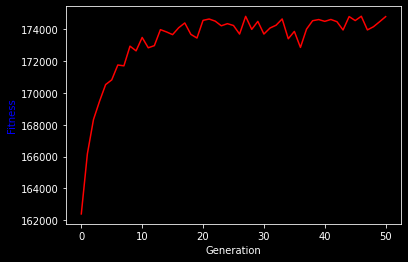

In [2006]:
gen = logbook.select("gen")
avgs = logbook.select("avg")

fig = plt.figure()

ax = plt.gca()
line = ax.plot(gen, avgs, "r-", label="Average Fitness")
ax.set_xlabel("Generation")
ax.set_ylabel("Fitness", color="b")

plt.plot()

In [2007]:
def get_rides_from_ind(individual):
    car_rides = np.full(F, None)
    
    for i, car in enumerate(individual):
        v_r = car_rides[car]
        
        if v_r is None:
            v_r = []
            
        ride = rides[i]
        v_r.append([i, ride])
        
        car_rides[car] = v_r

    return car_rides
    

In [2008]:
outDirPath = "../../Output/"
outFilePath = outDirPath + file_name.strip(".in") + ".out"

# For the output we need to reverse the rides sorting.
ind = np.full(N, None)

for b, o in zip(best_sol, order):
    ind[o] = b

vehicles_rides = get_rides_from_ind(ind)

with open(outFilePath, "w") as f:
    for v_r in vehicles_rides:
        if v_r is None:
            f.write(str(0))
        else:
            v_r = sort_rides(v_r)
            f.write(str(len(v_r)))
            f.write(" ")
            f.write(" ".join(str(pos) for pos, _ in v_r))

        f.write("\n")
